# 変分法と変分量子固有値ソルバー法を学習する

この実習では、変分法の基本的な考え方と、その方法に基づいた変分量子アルゴリズムと呼ばれる量子計算の手法を学びます。特に、量子計算と古典計算を組み合わせた「**量子・古典ハイブリッドアルゴリズム**」としての変分量子アルゴリズムに着目します。この手法を用いて、近似的な固有値計算を可能にする**変分量子固有値ソルバー法**と呼ばれる方法へ拡張していきます。

この教材は、Qiskit textbookの["Simulating Molecules using VQE"](https://qiskit.org/textbook/ch-applications/vqe-molecules.html)を参考にしています。

```{contents} 目次
---
local: true
---
```

$\newcommand{\ket}[1]{| #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 |}$
$\newcommand{\braket}[2]{\langle #1 | #2 \rangle}$
$\newcommand{\expval}[3]{\langle #1 | #2 | #3 \rangle}$

## はじめに
行列で表現されるある物理系に対して、その最も小さい固有値を見つけるという操作は、多くのアプリケーションで必要となる重要な技術です。例えば化学の計算では、分子を特徴づけるエルミート行列の最小固有値はそのシステムの最もエネルギーの低い状態（基底状態）のエネルギーになります。最小固有値を見つけるには「**量子位相推定**」と呼ばれる手法（この{doc}`課題 <spectrum_estimation>`を参照）を使うことができますが、この手法を使って実用的な問題を解こうとすると、そのために必要な量子回路はNISQコンピュータでは実現できないほど長くなることが知られています。そのために、短い量子回路を利用して分子の基底状態エネルギーを推定する手法として、**変分量子固有値ソルバー法**（*Variational Quantum Eigensolver*, VQE）が提案されました {cite}`vqe`。

まず、VQEの元になる関係を形式的に表現してみましょう。何か分からない最小固有値$\lambda_{min}$とその固有状態$\ket{\psi_{min}}$をもったエルミート行列$H$が与えられたとして、VQEはその系のエネルギーの下限である$\lambda_{min}$の近似解$\lambda_{\theta}$を求める手法です。つまり

$$
\lambda_{min} \le \lambda_{\theta} \equiv \expval{ \psi(\theta)}{H}{\psi(\theta) }
$$

を満たす、できるだけ小さい$\lambda_{\theta}$を求めることに対応します。ここで$\ket{\psi(\theta)}$は近似解$\lambda_{\theta}$に対応する固有状態で、$\theta$はパラメータです。つまり、適当な初期状態$\ket{\psi}$にユニタリー$U(\theta)$で表現されるパラメータ化された回路を適用することで、$\ket{\psi_{min}}$を近似する状態$\ket{\psi(\theta)} \equiv U(\theta)\ket{\psi}$を得ようというアイデアです。最適なパラメータ$\theta$の値は、期待値 $\expval{\psi(\theta)}{H}{\psi(\theta)}$が最小になるように古典計算を繰り返しながら求めていくことになります。

## 量子力学における変分法

### 背景

VQEは量子力学の**変分法**を応用した手法です。変分法をより良く理解するために、基礎的な数学的背景を見てみましょう。

行列$A$の固有ベクトル$\ket{\psi_i}$とその固有値$\lambda_i$は、$A \ket{\psi_i} = \lambda_i \ket{\psi_i}$という関係を持っていますね。行列$H$がエルミート行列$H = H^{\dagger}$の場合、スペクトル定理から$H$の固有値は実数になります（$\lambda_i = \lambda_i^*$）。実際に実験で測定できる量は実数である必要があるため、量子系のハミルトニアンを記述するためにはエルミート行列が適切です。さらに、$H$は以下のように表現することもできます。

$$
H = \sum_{i = 1}^{N} \lambda_i \ket{\psi_i} \bra{ \psi_i }
$$

ここで、各$\lambda_i$は固有ベクトル$\ket{\psi_i}$に対応する固有値です。任意の量子状態$\ket{\psi}$に対して観測量$H$を測定した時の期待値は、以下の式で与えられます。

$$
\langle H \rangle_{\psi} \equiv \expval{ \psi }{ H }{ \psi }
$$

上式の$H$を期待値の式に代入すると

$$
\begin{aligned}
\langle H \rangle_{\psi} = \expval{ \psi }{ H }{ \psi } &= \bra{ \psi } \left(\sum_{i = 1}^{N} \lambda_i \ket{\psi_i} \bra{ \psi_i }\right) \ket{\psi}\\
&= \sum_{i = 1}^{N} \lambda_i \braket{ \psi }{ \psi_i} \braket{ \psi_i }{ \psi} \\
&= \sum_{i = 1}^{N} \lambda_i | \braket{ \psi_i }{ \psi} |^2
\end{aligned}
$$

になります。最後の式は、任意の状態$\ket{\psi}$に対する$H$の期待値は、$\lambda_i$を重みとした固有ベクトル$\ket{\psi_i}$と$\ket{\psi}$の内積（の絶対値二乗）の線形結合として与えられることを示しています。この式から、$| \braket{ \psi_i }{ \psi} |^2 \ge 0$ であるために

$$
\lambda_{min} \le \langle H \rangle_{\psi} = \expval{ \psi }{ H }{ \psi } = \sum_{i = 1}^{N} \lambda_i | \braket{ \psi_i }{ \psi} |^2
$$

が成り立つことは明らかです。上記の式が**変分法**と呼ばれるもの（テキストによっては**変分原理**と呼ぶ）で、波動関数を「うまく取る」ことで、ハミルトニアン$H$の期待値の下限として最小固有値を近似的に求めることができることを表しています。この式から、$\ket{\psi_{min}}$状態の期待値は$\expval{ \psi_{min}}{H}{\psi_{min}} = \expval{ \psi_{min}}{\lambda_{min}}{\psi_{min}} = \lambda_{min}$になることも分かるでしょう。

### 基底状態の近似
系のハミルトニアンがエルミート行列$H$で表現されている場合、系の基底状態のエネルギーは$H$の最小固有値になります。まず$\ket{\psi_{min}}$の初期推定としてある波動関数$\ket{\psi}$（*Ansatz*と呼ばれる）を選び、その状態での期待値$\langle H \rangle_{\psi}$を計算します。変分法の鍵は、この期待値が小さくなるように波動関数を更新しながら計算を繰り返し、ハミルトニアンの基底状態エネルギーに近づけていくところにあります。

(vqa)=
## 変分量子アルゴリズム

まず、VQEの元になっている**変分量子アルゴリズム**（*Variational Quantum Algorithm*, VQA）と呼ばれる手法について見ていきます。

### 変分量子回路
量子コンピューター上で変分法を実装するには、*Ansatz*を更新する仕組みが必要です。量子状態の更新には量子ゲートが使えることを、私たちは知っていますね。VQAも量子ゲートを使いますが、VQAは決まった構造を持つパラメータ化された量子回路（**変分量子回路**と呼ばれる）を使って行います。この回路は**変分フォーム**（*variational form*）と呼ばれる場合もあり、回路をひとまとめにしてユニタリー変換$U(\theta)$と書くことも多いです（$\theta$はパラメータで、複数ある場合はベクトルになります）。

変分フォームを初期状態$\ket{\psi}$（例えば標準状態$\ket{0}$）に適用すると、出力として$\ket{\psi(\theta)} \equiv U(\theta)\ket{\psi}$が生成されます。この状態の元で期待値$\expval{ \psi(\theta)}{H}{\psi(\theta)}$が$\lambda_{min}$に近付くように、$\ket{\psi(\theta)}$に対してパラメータ$\theta$の最適化を行うのがVQEです。パラメータの最適化は古典計算で実行することを想定しており、その意味でVQEは典型的な**量子・古典ハイブリッドアルゴリズム**の一つです。

変分フォームの決め方ですが、解きたい問題のドメインに応じて特定の構造を持つ変分フォームを導入することがあります。そうではなく、幅広い問題への応用ができるようにドメインに依存しない形の変分フォーム（例えば$R_X$や$R_Y$などの回転ゲート）を使うこともあります。後で高エネルギー実験へのVQEの応用を課題として考えますが、そこでは$R_Y$と制御$Z$ゲートを使った変分フォームを実装します。

### 単純な変分フォーム
変分フォームを決める時には、2つの相反する目的に対するバランスを考える必要があります。$n$量子ビットの変分フォームは、パラメータの数を増やせば$\ket{\psi} \in \mathbb{C}^N$（$N=2^n$）の任意の状態ベクトル$\ket{\psi}$を生成できるでしょう。しかし、パラメータを最適化することを考えれば、できるだけ少ないパラメータで変分フォームを構築したいですよね。回転角をパラメータとする回転ゲートの数が増えれば、量子コンピュータで動かす場合はそれだけノイズの影響を受けやすくなります。なので、できるだけ少ないパラメータ（やゲート）で求める状態を生成できればベストでしょう。

ここでは、まず$n=1$の場合を考えます。$U3$ゲートは3つのパラメータ$\theta$、$\phi$、$\lambda$を使って以下の変換を表現します:

$$
U3(\theta, \phi, \lambda) = \begin{pmatrix}\cos\frac{\theta}{2} & -e^{i\lambda}\sin\frac{\theta}{2} \\ e^{i\phi}\sin\frac{\theta}{2} & e^{i\lambda + i\phi}\cos\frac{\theta}{2} \end{pmatrix}
$$

系全体にかかるグローバルな位相を除けば、3つのパラメータを適切に設定して実装すれば任意の単一量子ビット状態への変換が行えます。そういう意味で、この変分フォームは**ユニバーサル**な変換が可能で、かつ3つしかパラメータがないため効率的に最適化できるという特徴があります。ただユニバーサルに任意の状態を生成できるということは、この変分フォームが生成する状態を使ってあるハミルトニアン$H$の期待値を計算しようとした場合、その固有状態を近似する状態だけでなく、それ以外のさまざまな状態も含むということになります。つまり、VQEで最小固有値を効率的に決めるためには、こういう不要な状態を避けつつ、古典計算でいかに適切にパラメータを最適化できるかにかかっているわけです。

### パラメータの最適化
パラメータ化された変分フォームを選択したら、所望の量子状態を作ることができるように、変分法に従ってパラメータを最適化する必要があります。パラメータの最適化のプロセスには様々な課題があります。例えば量子ハードウェアには様々なタイプのノイズがあるため、その状態でエネルギーを測定しても正しい答えが返ってくるという保証はありません。そのために、パラメータの最適化に使う目的関数の評価が実際のエネルギーの値からずれてしまい、正しくパラメータの更新ができない可能性があります。また、最適化の手法（**オプティマイザー**）によっては、パラメータの数に依って目的関数を評価する回数が増えることがあり、ノイズの影響をさらに受けやすくなります。つまり、アプリケーションの要求を考慮しながら、オプティマイザーの選択にも気を配る必要があります。

最も一般的な最適化手法は、エネルギーの減少が極大になるような方向に各パラメータを更新する**勾配降下法**です。各パラメータごとに勾配を計算するため、最適化すべきパラメータの数に応じて目的関数を評価する回数は増えます。また、この性質から探索空間の中で局所的な最適値を素早く発見することは可能ですが、逆に探索が局所的な最小値に留まってしまうことがあります。勾配降下法は直感的で理解しやすい最適化の手法ですが、少なくとも現在のNISQコンピュータでは精度良く実行することは難しいと考えられています（VQEを実装する時に、勾配計算を使った最適化の方法を紹介します）。

ノイズのある量子コンピュータで目的関数を最適化する適切なオプティマイザーとして、*Simultaneous Perturbation Stochastic Approximation*（**SPSA**）{cite}`bhatnagar_optimization`があります。SPSAは２回の測定だけで目的関数の勾配を近似できるという特徴があります。勾配降下法では各パラメータを独立に変化させるのに対して、SPSAでは全てのパラメータを同時にランダムに変化させます。以上のことから、VQEを利用する場合のオプティマイザーとしてSPSAが推奨されることがあります。

ノイズがない量子コンピュータで目的関数を評価する場合（例えば状態ベクトルシミュレータで実行する場合など）は、Pythonの[SciPy](https://www.scipy.org/scipylib/index.html)パッケージで提供されているオプティマイザーなど、様々な選択肢があります。この実習では、Qiskit Aquaでサポートされているオプティマイザーの中で、特に*Constrained Optimization by Linear Approximation*（**COBYLA**）と呼ばれるオプティマイザーも使用します。COBYLAは目的関数の評価を1回しか実行しない（つまり評価の回数がパラメータの数に依存しない）ため、ノイズがない状態でかつ評価の回数を少なくしたい場合にはCOBYLAの利用が推奨されているようです。いずれにしろ、どのオプティマイザーがベストかはVQEアルゴリズムの実装形式や実行環境によって変わるため、ある程度経験によって決める必要があると考えられます。

### 変分フォームを使った実例
ではここで、単一量子ビットの変分フォームを利用してパラメータ最適化の例を実行してみましょう。例として、ランダムな確率分布のベクトル$\vec{x}$（要素数は2）を入力として与えた時、出力の確率分布が$\vec{x}$に近くなるように単一量子ビットの変分フォームを決定するという問題を考えます（2つの確率分布の近さはL1距離によって定義します）。

```{image} figs/vqe_u3.png
:alt: vqe_u3
:width: 400px
:align: center
```

最初に、Pythonでランダムな確率分布のベクトルを作成します。

In [1]:
# Tested with python 3.8.12, qiskit 0.34.2, numpy 1.22.2
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.algorithms.optimizers import SPSA, COBYLA

In [2]:
nq = 1  # 量子ビットの数

npar = 3*nq  # パラメータの数

np.random.seed(999999)
target_distr = np.random.rand(2**nq)
target_distr /= sum(target_distr)

次に、単一の$U3$変分フォームの3つのパラメータを引数として受け取り、対応する量子回路を返す関数を定義します。

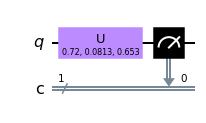

In [3]:
def get_var_form(params):
    qr = QuantumRegister(nq, name="q")
    cr = ClassicalRegister(nq, name='c')
    qc = QuantumCircuit(qr, cr)

    for i in range(nq):
        qc.u(params[3*i], params[3*i+1], params[3*i+2], qr[i])

    for i in range(nq):
        qc.measure(qr[i], cr[i])
    return qc

get_var_form(np.random.rand(npar)).draw('mpl')

変分フォームのパラメータのリストを入力とし、パラメータに対応したコストを計算する目的関数を定義します。アルゴリズムを実行するバックエンドとして、**QASMシミュレータ**を使用します。

In [4]:
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000  # 測定する回数

# 出力されるビット列の確率分布を計算
def get_probability_distribution(counts):
    output_distr = []
    for i in range(2**nq):
        match = False
        for (k,v) in counts.items():
            if i == int(k,2):
                output_distr.append(v/NUM_SHOTS)
                match = True
        if not match:
            output_distr.append(0)

    if len(output_distr) == 1:
        output_distr.append(0)
    return output_distr

# コストを計算する目的関数を定義
def objective_function(params):
    qc = get_var_form(params)
    qc = transpile(qc, backend=backend)
    result = backend.run(qc, shots=NUM_SHOTS).result()
    output_distr = get_probability_distribution(result.get_counts(qc))
    cost = sum([np.abs(output_distr[i] - target_distr[i]) for i in range(2**nq)])
    return cost

最後にCOBYLAオプティマイザーのインスタンスを作成し、アルゴリズムを実行します。出力される確率分布は実行の度に異なり、ターゲットの確率分布と完全には同じにならないことに注意してください。出力の精度は量子計算の回数（ショット数＝NUM_SHOTS）に依存するので、ショット数を増減させた時の一致具合を確認してみてください。

In [5]:
optimizer = COBYLA(maxiter=500, tol=0.0001)

params = np.random.rand(npar)
ret = optimizer.optimize(num_vars=npar, objective_function=objective_function, initial_point=params)

qc = get_var_form(ret[0])
qc = transpile(qc, backend=backend)
counts = backend.run(qc, shots=NUM_SHOTS).result().get_counts(qc)
output_distr = get_probability_distribution(counts)

print("Target Distribution:         ", np.round(target_distr,4))
print("Obtained Distribution:       ", np.round(np.array(output_distr),4))
print("Cost Value (L1-Distance):     {:.6f}".format(ret[1]))
print("Parameters Found:            ", np.round(ret[0],4))

Target Distribution:          [0.5136 0.4864]
Obtained Distribution:        [0.5095 0.4905]
Cost Value (L1-Distance):     0.019340
Parameters Found:             [1.5463 0.0381 0.7142]


では次に、この問題を2量子ビット（確率分布の要素数は4）に拡張してやってみましょう。上に戻って

In [6]:
nq = 2  # 量子ビットの数

として再度実行するとどういう結果が得られるでしょうか。量子回路とオプティマイザーの関係はこのようになってますね。

```{image} figs/vqe_2q_u3.png
:alt: vqe_2q_u3
:width: 500px
:align: center
```

やってみると分かりますが、結果は1量子ビットの場合と比べて良くないですね。どうすれば良くなるでしょうか？（やり方は複数あると思います）

**一つの解決策：変分フォームにエンタングルメントを導入する**

```python
    for i in range(nq):
        qc.u(params[3*i], params[3*i+1], params[3*i+2], qr[i])
    qc.cx(qr[0],qr[1])
```

どうなるか確かめてください。

量子ビットをエンタングルさせることで相関のあるデータを表現しやすくなるという状況は、例えば、ベル状態（[CHSH不等式の破れを確認する](https://utokyo-icepp.github.io/qc-workbook/chsh_inequality.html#id14)を参照）の確率分布を再現したいときにクリアに見ることができます。上で

In [7]:
target_distr = np.random.rand(2**nq)

を

In [8]:
# 00と11を測定する確率が50%、01と10の確率は0
target_distr = np.array([0.5,0.,0.,0.5])

として実行するとどうなるでしょうか。エンタングルさせる場合とさせない場合で大きな違いが見えるでしょう。3量子ビットのGHZ状態（[単純な量子回路をゼロから書く](https://utokyo-icepp.github.io/qc-workbook/circuit_from_scratch.html#ghz)を参照）

In [9]:
# 000と111を測定する確率が50%、それ以外の確率は0
target_distr = np.array([0.5,0.,0.,0.,0.,0.,0.,0.5])

に拡張してみるなどして、遊んでみてください。

(vqe)=
## 変分量子固有値ソルバー法

それでは、ここからVQEの簡単な実装例を見ていくことにします。

(param_shift)=
### パラメータシフト法
VQEを実装する前に、目的関数の勾配を使った最適化の方法（**パラメータシフト法**と呼ばれる）について説明します。あるタイプの変分量子回路では、目的関数の勾配を厳密に計算できることが知られています。その勾配の値を使って、古典計算でパラメータを最適化することができます。

パラメータシフト法を使って勾配を導出するために、まず一般的なパラメータ付きユニタリー演算$U({\boldsymbol \theta})=\prod_{j=1}^LU_j(\theta_j)$を考えます。$U_j(\theta_j)$はパラメータ$\theta_j$を持つユニタリーで、例えば$\theta_j$を回転角とする回転ゲート$U_j(\theta_j)=\exp(-i\theta_jP_j/2)$を考えてみます（$P_j\in\{X,Y,Z\}$はパウリ演算子です）。初期状態$\rho$を$U({\boldsymbol \theta})$で時間発展させた状態に対して、物理量$M$を測定したときの期待値$\langle M({\boldsymbol \theta})\rangle$は

$$
\langle M({\boldsymbol \theta})\rangle=\text{Tr}\left[MU({\boldsymbol \theta})\rho U({\boldsymbol \theta})^\dagger\right] = \text{Tr}\left[MU_{L:1}\rho U_{L:1}^\dagger\right]
$$

になります（ここで$U_{l:m}:=\prod_{j=m}^lU_j(\theta_j)$と略記することにします）。この期待値のパラメータ$\theta_j$に対する勾配は

$$
\frac{\partial}{\partial\theta_j}\langle M({\boldsymbol \theta})\rangle=\text{Tr}\left[M\frac{\partial U_{L:1}}{\partial\theta_j}\rho U_{L:1}^\dagger\right]+\text{Tr}\left[MU_{L:1}\rho\frac{\partial U_{L:1}^\dagger}{\partial\theta_j}\right]
$$

です。$P_j^\dagger=P_j$なので

$$
\begin{aligned}
\frac{\partial U_{L:1}}{\partial\theta_j} &= U_L\ldots U_{j+1}\frac{\partial U_j}{\partial\theta_j}U_{j-1}\ldots U_1=-\frac{i}{2}U_{L:j}P_jU_{j-1:1} \\
\frac{\partial U_{L:1}^\dagger}{\partial\theta_j} &=\frac{i}{2}U_{j-1:1}^\dagger P_jU_{L:j}^\dagger
\end{aligned}
$$

という関係が成り立ちますが、この関係から

$$
\frac{\partial}{\partial\theta_j}\langle M({\boldsymbol \theta})\rangle=-\frac{i}{2}\text{Tr}\left[MU_{L:j}\left[P_j,U_{j-1:1}\rho U_{j-1:1}^\dagger\right]U_{L:j}^\dagger\right]
$$

が得られます。ここで$U_j(\theta_j)$の定義に戻ると、$U_j(\theta_j)=\exp(-i\theta_jP_j/2)=\cos(\theta_j/2)I-i\sin(\theta_j/2)P_j$（$I$は恒等演算子）なので、$U(\pm\pi/2)=(1/\sqrt{2})(I\mp iP_j)$になります。従って、

$$
U_j\left(\frac{\pi}{2}\right)\rho U_j^\dagger\left(\frac{\pi}{2}\right)-U_j\left(-\frac{\pi}{2}\right)\rho U_j^\dagger\left(-\frac{\pi}{2}\right) = \frac12\left(I-iP_j\right)\rho\left(I+iP_j^\dagger\right)-\frac12\left(I+iP_j\right)\rho\left(I-iP_j^\dagger\right) = -i[P_j,\rho]
$$

と書くことができます。この結果を上の$\partial\langle M({\boldsymbol \theta})\rangle/\partial\theta_j$の式に適用すると、

$$
\begin{aligned}
\frac{\partial}{\partial\theta_j}\langle M({\boldsymbol \theta})\rangle &=-\frac{i}{2}\text{Tr}\left[MU_{L:j}[P_j,U_{j-1:1}\rho U_{j-1:1}^\dagger]U_{L:j}^\dagger\right] \\
&= \frac12\text{Tr}\left[MU_{L:j+1}U_j\left(\theta_j+\frac{\pi}{2}\right)U_{j-1:1}\rho U_{j-1:1}^\dagger U_j^\dagger\left(\theta_j+\frac{\pi}{2}\right) U_{L:j+1}^\dagger-MU_{L:j+1}U_j\left(\theta_j-\frac{\pi}{2}\right)U_{j-1:1}\rho U_{j-1:1}^\dagger U_j^\dagger\left(\theta_j-\frac{\pi}{2}\right) U_{L:j+1}^\dagger)\right] \\
&= \frac12\left[\left\langle M\left({\boldsymbol \theta}+\frac{\pi}{2}{\boldsymbol e}_j\right)\right\rangle - \left\langle M\left({\boldsymbol \theta}-\frac{\pi}{2}{\boldsymbol e}_j\right)\right\rangle\right]
\end{aligned}
$$

が得られます。ここで${\boldsymbol e}_j$は$j$番目の要素だけが1でそれ以外は0のベクトルです。

この式から、期待値$\langle M({\boldsymbol \theta})\rangle$のパラメータ$\theta_j$に対する勾配は、$\theta_j$を$\pm\pi/2$だけ増減させて求めた期待値の差として求めることができることが分かりました。これがパラメータシフト法と呼ばれるものです。

(vqe_imp)=
### VQEの実装
では、パラメータシフト法を使って簡単なVQEの例を実装してみます。ある観測量の期待値が最小になるように、VQEを使ってAnsatzを更新する回路パラメータを決定するという問題を考えてみます。

量子回路として、$R_YR_Z$ゲートを繰り返すシンプルなパラメータ回路を使うことにします。

In [10]:
# Tested with python 3.8.12, qiskit 0.34.2, numpy 1.22.2
from qiskit.circuit import ParameterVector
from qiskit.utils import QuantumInstance
from qiskit.opflow import I, X, Y, Z, StateFn, CircuitStateFn
from qiskit.opflow.gradients import Gradient
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import CG, GradientDescent

In [11]:
n = 3   # 量子ビット数
nl = 2  # レイヤー数
npar = n*2*nl   # パラメータ数

qc = QuantumCircuit(n)
param_list = ParameterVector('param_list',npar)
for i in range(nl):
    qc.ry(param_list[6*i], 0)
    qc.ry(param_list[6*i+1], 1)
    qc.ry(param_list[6*i+2], 2)
    qc.rz(param_list[6*i+3], 0)
    qc.rz(param_list[6*i+4], 1)
    qc.rz(param_list[6*i+5], 2)
    #qc.cnot(0, 1)
    #qc.cnot(1, 2)

観測量として、パウリ演算子のテンソル積$ZXY$を使います。

パラメータシフト法の実装は、QiskitではGradientというAPIを使うことで一行で済んでしまいます（実際の勾配計算に興味がある人は、期待値から勾配を直接求めるコードを書いて、パラメータ毎に$\pm\pi/2$シフトさせた回路を走らせることで、このAPIと同じ勾配が得られることを確認してみて下さい）。パラメータの最適化は、勾配を使って勾配降下を行うConjugate Descent (CG)とGradient Descentの2つのオプティマイザーを使って行いますが、比較のためにCOBYLAも使うことにします。

最終的に、3通りのVQEを使って求めた最小エネルギーの近似解を、厳密対角化して求めた最小エネルギーの値と比較することにします。

In [12]:
obs = Z ^ X ^ Y

grad = Gradient(grad_method="param_shift")
cg = CG(maxiter=200)
gd = GradientDescent(maxiter=200)
cobyla = COBYLA(maxiter=300)

In [13]:
# テキスト作成用のセル

import os
if os.getenv('JUPYTERBOOK_BUILD') == '1':
    del qc

In [14]:
random_seed = 10598
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend,
                                   shots=1024,
                                   seed_simulator=random_seed,
                                   seed_transpiler=random_seed,
                                   skip_qobj_validation=True)
# VQEアルゴリズムの実装
vqe_gfree = VQE(ansatz=qc, optimizer=cobyla, quantum_instance=quantum_instance)
result_vqe_gfree = vqe_gfree.compute_minimum_eigenvalue(obs)

vqe_cg = VQE(ansatz=qc, optimizer=cg, gradient=grad, quantum_instance=quantum_instance)
result_vqe_cg = vqe_cg.compute_minimum_eigenvalue(obs)

vqe_gd = VQE(ansatz=qc, optimizer=gd, gradient=grad, quantum_instance=quantum_instance)
result_vqe_gd = vqe_gd.compute_minimum_eigenvalue(obs)

# 厳密解
ee = NumPyMinimumEigensolver()
result_ee = ee.compute_minimum_eigenvalue(obs)

NameError: name 'qc' is not defined

In [15]:
# テキスト作成用のセルなので無視してよい

import pickle
with open('data/vqe_results.pkl', 'rb') as source:
    result_ee, result_vqe_gfree, result_vqe_cg, result_vqe_gd = pickle.load(source)

In [16]:
print('Result:')
print(f'  Exact      = {result_ee.eigenvalue}')
print(f'  VQE(GFree) = {result_vqe_gfree.optimal_value}')
print(f'  VQE(CG)    = {result_vqe_cg.optimal_value}')
print(f'  VQE(GD)    = {result_vqe_gd.optimal_value}')

Result:
  Exact      = -1.0
  VQE(GFree) = -0.9882812499999999
  VQE(CG)    = -0.99609375
  VQE(GD)    = -0.013671875000000014


COBYLAを使ってVQEで求めた答えは、厳密解(=-1.0)に近くなっていると思います。勾配計算を使ったVQEも多くの場合正しい答えに近い答えを返しますが、パラメータの初期値によってかなり悪い結果を返してしまう場合があります。

Ansatzの回路構成を変えたり、観測量を変えてみるなどして色々試してみてください。

## 参考文献

```{bibliography}
:filter: docname in docnames
```